In [1]:
import torch
import torch.nn.functional as F
from torch import nn

from einops import rearrange
from einops.layers.torch import Rearrange

from traj_dataset import TrajDataset
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD, Adagrad
from torch.nn import MSELoss
import matplotlib.pyplot as plt

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)


def posemb_sincos_3d(patches, temperature = 10000, dtype = torch.float32):
    _, f, h, w, dim, device, dtype = *patches.shape, patches.device, patches.dtype

    z, y, x = torch.meshgrid(
        torch.arange(f, device=device),
        torch.arange(h, device=device),
        torch.arange(w, device=device),
        indexing='ij')

    fourier_dim = dim // 6

    omega = torch.arange(fourier_dim, device = device) / (fourier_dim - 1)
    omega = 1. / (temperature ** omega)

    z = z.flatten()[:, None] * omega[None, :]
    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :]

    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos(), z.sin(), z.cos()), dim = 1)

    pe = F.pad(pe, (0, dim - (fourier_dim * 6))) # pad if feature dimension not cleanly divisible by 6
    return pe.type(dtype)


# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, out_dim=None):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, out_dim if out_dim else dim),
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Linear(inner_dim, dim, bias = False)

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads=heads, dim_head=dim_head),
                FeedForward(dim, mlp_dim)
            ]))


    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.linear = nn.Linear(1024, 4)

    def forward(self, x):
        x = self.linear(x)

        return x


class SimpleViT(nn.Module):

    def __init__(self, *, image_size=(64, 64), image_patch_size=(16, 16), frames=8, frame_patch_size=4, dim, depth=6, heads=8, mlp_dim=1024,device, channels=1, dim_head=64):
        super().__init__()

        self.device = device

        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(image_patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'
        assert frames % frame_patch_size == 0, 'Frames must be divisible by the frame patch size'

        num_patches = (image_height // patch_height) * (image_width // patch_width) * (frames // frame_patch_size)
        patch_dim = channels * patch_height * patch_width * frame_patch_size

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b (f pf) (h p1) (w p2) -> b f h w (p1 p2 pf)', p1=patch_height, p2=patch_width, pf=frame_patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        ).to(self.device)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim).to(self.device)

        self.to_latent = nn.Identity()
        self.linear_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, 24)
        )


        self.myNet = MyNet().to(device)

        self.decoderLayer = nn.TransformerDecoderLayer(d_model=dim,nhead=heads,batch_first=True).to(self.device)
        self.decoder = nn.TransformerDecoder(self.decoderLayer,depth).to(self.device)

        self.tgt_linear = nn.Linear(4096,1024).to(device)


        self.outputLinear = nn.Linear(dim,4).to(self.device)

    def forward(self, video,tgt,train=True):
        *_, h, w, dtype = *video.shape, video.dtype
        video = video.to(self.device)


        x = self.to_patch_embedding(video)

        pe = posemb_sincos_3d(x)
        x = rearrange(x, 'b ... d -> b (...) d') + pe

        x = self.transformer(x)

        x = self.generate_sequence(tgt,x,train)
        output = x

        x = self.myNet(x[:, :-1, :])

        if train:
            return x
        else:
            return x,output

    def generate_sequence(self,tgt, memory,train):
        # Initialize the decoder input with a special start-of-sequence token



        if tgt is not None:

            if train:
                tgt = torch.flatten(tgt,start_dim=-2,end_dim=-1)

                tgt = self.tgt_linear(tgt)

                # mask = torch.nn.Transformer.generate_square_subsequent_mask(tgt.shape[1],device)

                    # Create a tensor of size [10, 1, 1024] containing the SOS token
            sos = torch.ones(10, 1, 1024).to(device)
            # Concatenate the SOS tensor with your original tensor along the sequence length dimension
            tgt = torch.cat([sos, tgt], dim=1)
        else:
            tgt = torch.ones(10, 2, 1024).to(device)

        mask = torch.ones((tgt.shape[0]*8, tgt.shape[1], tgt.shape[1])).to(device)
        mask = mask.masked_fill(torch.tril(torch.ones((tgt.shape[1], tgt.shape[1])).to(device)) == 0, float('-inf'))

        output = self.decoder(tgt=tgt,memory=memory,tgt_mask=mask)

        return output













In [6]:
if __name__ == "__main__":

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    model = SimpleViT(dim=1024,device=device)



    optim = Adam(params=model.parameters(),lr=0.01)


Using device: cuda


In [3]:
dataset = TrajDataset("64_64_8", img_step=10,test=False,n_prev=8,n_next=8,n_traj=5,device=device)

test_dataset = TrajDataset("64_64_8", img_step=10,test=True,n_prev=8,n_next=8,device=device,n_traj=1)


opening track 0
tensor([[[0.5059, 0.5098, 0.5294,  ..., 0.3882, 0.3647, 0.3373],
         [0.4745, 0.4824, 0.5059,  ..., 0.4039, 0.4000, 0.3882],
         [0.4588, 0.4667, 0.4980,  ..., 0.4078, 0.4235, 0.4275],
         ...,
         [0.4902, 0.5255, 0.5294,  ..., 0.5373, 0.7137, 0.7490],
         [0.5059, 0.5098, 0.4824,  ..., 0.5373, 0.7608, 0.7608],
         [0.5294, 0.5255, 0.4980,  ..., 0.5608, 0.8196, 0.7922]]])
tensor([[[0.4902, 0.5020, 0.5255,  ..., 0.3961, 0.3647, 0.3255],
         [0.4784, 0.4902, 0.5137,  ..., 0.4039, 0.4000, 0.3843],
         [0.4667, 0.4784, 0.5098,  ..., 0.4000, 0.4196, 0.4275],
         ...,
         [0.4980, 0.5294, 0.5255,  ..., 0.5412, 0.7176, 0.7529],
         [0.4863, 0.4980, 0.4745,  ..., 0.5451, 0.7686, 0.7647],
         [0.5333, 0.5333, 0.5137,  ..., 0.5569, 0.8157, 0.7882]]])
tensor([[[0.4980, 0.5059, 0.5294,  ..., 0.4039, 0.3686, 0.3255],
         [0.4784, 0.4863, 0.5137,  ..., 0.4157, 0.4039, 0.3804],
         [0.4588, 0.4706, 0.5020,  ..., 0.

In [7]:
batch_size = 10
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)
criterion = MSELoss()

loss_evol = []

test_loss = []
"""
for id_b, batch in enumerate(test_loader):
    model.eval()
    with torch.no_grad():
        if len(batch["src"]) != batch_size: continue


        X_test = batch["src"]
        Y_test = batch["tgt"]
        TGT = batch["intermediate"]

        seq = []
        future = None
        for k in range(8):
            pred,output = model(X_test.to(device),future,train=False)
            future = output


            seq.append(pred)

        seq = torch.cat(seq,dim=1)
        l = criterion(pred,Y_test.to(device))
        test_loss.append(l.item())
"""
for epoch in range(5):
    print("Starting epoch: ", epoch)
    for id_b, batch in enumerate(train_loader):
        print(id_b)
        if len(batch["src"]) != batch_size: continue

        model.train()
        X_train = batch["src"]
        Y_train = batch["tgt"]
        TGT = batch["intermediate"]


        optim.zero_grad()
        pred = model(X_train.to(device),TGT.to(device))


        l = criterion(pred, Y_train.to(device))
        loss_evol.append(l.item())
        print(l.item())
        print(pred[0,0,:])
        print(Y_train[0,0,:])
        l.backward()
        optim.step()
        if id_b % 250 == 0:
            print("Testing")
            for id_b, batch in enumerate(test_loader):
                if id_b > 4: break
                model.eval()
                with torch.no_grad():
                    if len(batch["src"]) != batch_size: continue


                    X_test = batch["src"]
                    Y_test = batch["tgt"]
                    TGT = batch["intermediate"]

                    seq = []
                    future = None
                    for k in range(8):
                        pred,output = model(X_test.to(device),future,train=False)
                        future = output


                        seq.append(pred)

                    seq = torch.cat(seq,dim=1)
                    l = criterion(pred,Y_test.to(device))
                    test_loss.append(l.item())




Starting epoch:  0
0
1267.2548828125
tensor([1.7989, 0.7642, 0.2915, 0.3298], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([12., 22., 19., 29.])
Testing
1
1057.0003662109375
tensor([4.8781, 7.6681, 9.0601, 9.9018], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([ 6., 51., 13., 58.])
2
768.9725952148438
tensor([12.3737, 19.0596, 15.1558, 20.9798], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([-2.,  8.,  5., 15.])
3
591.4201049804688
tensor([23.9369, 25.8534, 24.1693, 26.8581], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([52., -1., 59.,  6.])
4
547.3209228515625
tensor([26.1165, 32.2724, 28.6881, 34.4922], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([ 9., 55., 16., 62.])
5
453.3170471191406
tensor([25.1441, 38.5114, 30.7474, 41.3219], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([52., -1., 59.,  6.])
6
386.8175964355469
tensor([20.8965, 41.6525, 29.6609, 46.0366], device='cuda:0',
       grad_fn=<SliceBackward0>)
ten

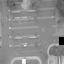

In [23]:
for id_b, batch in enumerate(test_loader):
    model.eval()
    with torch.no_grad():
        if len(batch["src"]) != batch_size: continue


        X_test = batch["src"]
        Y_test = batch["tgt"]
        TGT = batch["intermediate"]

        seq = []
        future = None
        for k in range(8):
            pred,output = model(X_test.to(device),future,train=False)
            future = output


            seq.append(pred)

        seq = torch.cat(seq,dim=1)
        l = criterion(pred,Y_test.to(device))
        test_loss.append(l.item())


KeyboardInterrupt: 

0.1758690544883921
[0.4214205741882324, 38.81151580810547, 12.579889297485352, 3.596402883529663, 1.4447969198226929, 0.2209175080060959, 1.3150677680969238, 1.0810612440109253, 0.8395459055900574, 0.21075783669948578, 0.17667275667190552, 0.2638548016548157, 0.4738062918186188, 0.5065054893493652, 0.4782423973083496, 0.32564598321914673, 0.12684564292430878, 0.1508418321609497, 0.14239156246185303, 0.15362957119941711, 0.22845952212810516, 0.25879421830177307, 0.17665021121501923, 0.20082926750183105, 0.25144705176353455, 0.16822683811187744, 0.09525179117918015, 0.09214004129171371, 0.10815286636352539, 0.10351116955280304, 0.20967307686805725, 0.12238850444555283, 0.1986037641763687, 0.15679419040679932, 0.11046367138624191, 0.10890930145978928, 0.10690770298242569, 0.08067711442708969, 0.126799076795578, 0.1517644226551056, 0.06271649897098541, 0.09144163876771927, 0.09275966137647629, 0.11975008249282837, 0.09850159287452698, 0.1277787983417511, 0.08856459707021713, 0.125493168830

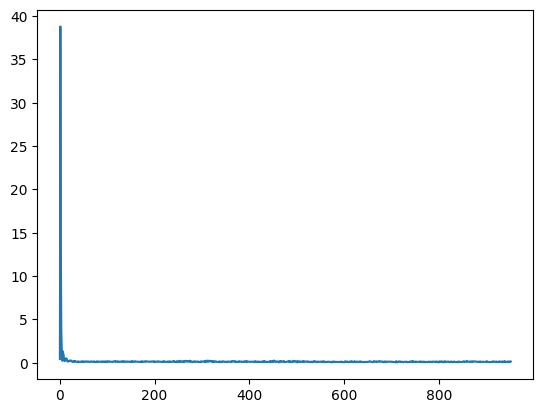

In [10]:
import numpy as np

print(np.mean(loss_evol))
print(loss_evol)
plt.plot(loss_evol)
print(loss_evol)
plt.show()

10.288960757665336


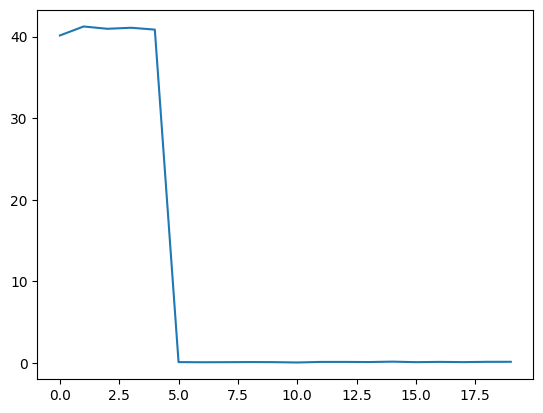

In [11]:
print(np.mean(test_loss))
plt.plot(test_loss)
plt.show()



Test Batch 0
tensor([0.4745, 0.4941, 0.4824, 0.5098, 0.4980, 0.4863, 0.5059, 0.4196, 0.4118,
        0.4196, 0.4471, 0.4510, 0.4314, 0.4588, 0.4784, 0.4549, 0.4549, 0.4588,
        0.4118, 0.4000, 0.4235, 0.4039, 0.4667, 0.6353, 0.6392, 0.7137, 0.7020,
        0.6275, 0.6039, 0.5922, 0.5490, 0.5216, 0.5020, 0.5020, 0.5098, 0.5176,
        0.5216, 0.5098, 0.4824, 0.4588, 0.4667, 0.4863, 0.5098, 0.5294, 0.5412,
        0.5529, 0.5647, 0.5765, 0.5608, 0.5608, 0.5451, 0.5216, 0.4902, 0.4745,
        0.4784, 0.4863, 0.4706, 0.4000, 0.3686, 0.3725, 0.3765, 0.3922, 0.3765,
        0.3176])
tensor([0.3130, 0.7314, 0.2888, 0.5995], device='cuda:0')
torch.Size([10, 8, 4])
tensor(0.1048, device='cuda:0')


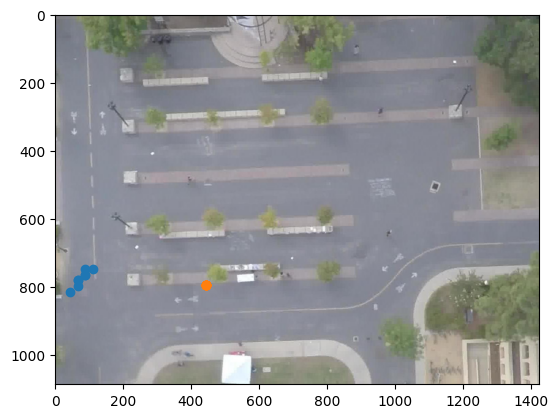

In [38]:
for id_b2, batch_test in enumerate(test_loader):


    with torch.no_grad():
        print(f"Test Batch {id_b2}")
        if len(batch_test["src"]) != batch_size: continue
        model.eval()

        X_test = batch_test["src"]
        Y_test = batch_test["tgt"]
        TGT = batch["intermediate"]


        seq = []
        future = None
        """
        for k in range(2):
            pred,output = model(X_test.to(device),future,train=False)


            future = output

        """
        pred = model(X_test.to(device),TGT.to(device))
        print(X_test[0,0,0,:])
        print(pred[0,0,:])



        points = [(k[0],k[1]) for k in Y_test[7]]
        points2 = [(k[0],k[1]) for k in pred[7].cpu().detach().numpy()]
        x,y = zip(*points)
        x2,y2 = zip(*points2)

        print(pred.shape)
        print(criterion(pred,Y_test.to(device)))

        plt.scatter([k*1424 for k in x],[k*1088 for k in y], label="Truth")
        plt.scatter([k*1424 for k in x2],[k*1088 for k in y2],label="Prediction")
        plt.imread("reference.jpg")
        plt.imshow(plt.imread("reference.jpg"))
        plt.show()
        break
